#### LangGraph에서 도구(tool) 활용 방법

- 도구(tool)를 활용한 에이전트 개발 방법을 알아봅니다
- workflow를 직접 선언하지 않고, 사용가능한 도구들을 전달하면, 에이전트가 적합한 도구를 판단해서 사용합니다
    - 이번 회차에서는 `ToolNode`를 통해 도구를 활용하는 방법을 알아봅니다

In [1]:
from dotenv import load_dotenv
import os
# .env 파일을 불러와서 환경 변수로 설정
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
5L


In [2]:
from langchain_upstage import ChatUpstage
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
    )
print(llm)

c:\Users\Jeong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


client=<openai.resources.chat.completions.completions.Completions object at 0x0000027AB995A510> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000027AB995AF90> model_name='solar-pro' temperature=0.5 model_kwargs={} upstage_api_key=SecretStr('**********') upstage_api_base='https://api.upstage.ai/v1'


In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

- LangGraph는 `ToolNode`를 통해 도구를 활용합니다
- `ToolNode`의 `invoke()`결과는 도구의 `invoke()` 결과와 유사합니다
    - 도구는 도구의 실행 결과를 리턴하고, `ToolNode`는 도구의 실행 결과를 포함한 `ToolMessage`를 리턴합니다

In [4]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

print(type(llm_with_tools))
print(tool_node)

<class 'langchain_core.runnables.base.RunnableBinding'>
tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'add': StructuredTool(name='add', description='숫자 a와 b를 더합니다.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000027AB98C68E0>), 'multiply': StructuredTool(name='multiply', description='숫자 a와 b를 곱합니다.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000027AB98C6980>)}, tool_to_state_args={'add': {}, 'multiply': {}}, tool_to_store_arg={'add': None, 'multiply': None}, handle_tool_errors=True, messages_key='messages')


In [6]:
multiply.invoke({'a': 3, 'b': 5})

15

In [7]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')
ai_message

AIMessage(content="[The 'add' function is ESSENTIAL to directly compute the sum of 3 and 5, which is the core requirement of the question. No other function or general knowledge is needed.]", additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-a59863325989478ead0902ef1bde6535', 'function': {'arguments': '{"a": 3, "b": 5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 580, 'total_tokens': 639, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'solar-pro2-250909', 'system_fingerprint': None, 'id': 'b6039898-028e-431b-a57c-647f8d22d658', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a7e57734-e38b-48c3-af78-da9d497b14fa-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'chatcmpl-tool-

In [8]:
ai_message.tool_calls

[{'name': 'add',
  'args': {'a': 3, 'b': 5},
  'id': 'chatcmpl-tool-a59863325989478ead0902ef1bde6535',
  'type': 'tool_call'}]

- `ToolNode`를 `invoke()`하려면 `tool_calls` 속성을 포함한 `AIMessage`를 전달해야 합니다

In [9]:
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='chatcmpl-tool-a59863325989478ead0902ef1bde6535')]}

- 간단한 에이전트를 만들기 위해 LangGraph에서 제공하는 [`StateGraph`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)를 사용합니다

In [10]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    
    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

In [12]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정합니다.

    Args:
        state (MessagesState): `state`를 포함하는 객체.

    Returns:
        Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고, 
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    print(messages)
    
    # 마지막 AI 메시지를 가져옵니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
    return END

- `node`를 추가하고 `edge`로 연결합니다

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [15]:
graph= graph_builder.compile()
print(type(graph))

<class 'langgraph.graph.state.CompiledStateGraph'>


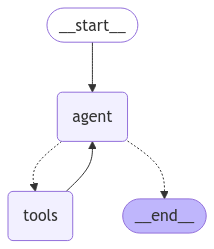

In [ ]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> tools;
	tools --> agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.


- `graph.stream()`을 활용하면 에이전트가 답변을 생성하는 과정을 모니터링 할 수 있습니다

In [17]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
[HumanMessage(content='3에다 5를 더하고 거기에 8을 곱하면?', additional_kwargs={}, response_metadata={}, id='9352e4da-b518-4aa0-8d85-7375483a9780'), AIMessage(content="[Brief explanation: The `add` function is ESSENTIAL to compute the sum of 3 and 5, and the `multiply` function is ESSENTIAL to multiply the result by 8. These are the MINIMUM necessary steps to answer the question.]  \n\nNote: The system should pass the result of `add` as `result_of_add` to `multiply`. If the tool doesn't support variable passing, the functions would need to be executed sequentially with manual result handling.  \n\nFinal answer: (3 + 5) × 8 = 8 × 8 = **64**.", additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-9740f6d3ec7c436385688de728b18d20', 'function': {'arguments': '{"a": 3, "b": 5}', 'name': 'add'}, 'type': 'function'}, {'id': 'chatcmpl-tool-b10c77ac65f54fc9b5a43e89f46c7634', 'function': {'arguments': 

#### LangGraph 내장 ReAct 에이전트 사용
* create_react_agent()의 작동 방식
    * create_react_agent() 함수 내부에서 이미 StateGraph와 필요한 노드(사고, 도구 실행, 응답 생성 등)를 자동으로 구성합니다.

In [ ]:
from langgraph.prebuilt import create_react_agent
from langchain.agents import tool

from langchain_core.messages import HumanMessage
from langchain_upstage import ChatUpstage

llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
    )
print(llm)

@tool
def add2(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

# 한 줄로 에이전트 생성 - 내부에서 StateGraph를 자동 구성
print(llm.model_name)
agent = create_react_agent(model=llm, tools=[add2])

# 바로 사용 가능
result = agent.invoke({"messages": [HumanMessage(content="3+5는?")]})

print(result)

c:\Users\Jeong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


client=<openai.resources.chat.completions.completions.Completions object at 0x000001D74989FA10> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001D749D64590> model_name='solar-pro' temperature=0.5 model_kwargs={} upstage_api_key=SecretStr('**********') upstage_api_base='https://api.upstage.ai/v1'
solar-pro
{'messages': [HumanMessage(content='3+5는?', additional_kwargs={}, response_metadata={}, id='4a0aceaf-fc21-4c36-ad99-3f915aed0f68'), AIMessage(content='8  \n(3 + 5의 결과는 일반적인 수학 지식으로 8이므로 함수 호출이 필요하지 않습니다.)', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 509, 'total_tokens': 531, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'solar-pro2-250909', 'system_fingerprint': None, 'id': '323bcf0a-018d-4ade-b46c-